In [1]:
import json
import pandas as pd
file_path = "C:/Nistha/Insta/SarcasmDetection/Sarcasm_Headlines_Dataset.json"
datastore=pd.read_json(file_path)

In [2]:

sentences = [] 
labels = []
urls = []
for _, row in datastore.iterrows():
    sentences.append(row['headline'])
    labels.append(row['is_sarcastic'])
    urls.append(row['article_link'])

In [3]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(len(word_index))
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post')
print(padded[0])
print(padded.shape) 

29657
[  308 15115   679  3337  2298    48   382  2576 15116     6  2577  8434
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(26709, 40)


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

# TrainTest Split

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

    Tokenization:
Converts words into numbers so they can be used in ML models.

    Padding:
Ensures all inputs have the same length 

    Out-of-Vocabulary Handling:
Prevents errors when encountering new words.

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Converts testing padded sequences and labels into NumPy arrays.

This ensures that test data has the same format as training data for model evaluation.

In [7]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# Model

In [8]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),      # words into dense vector representations
    tf.keras.layers.GlobalAveragePooling1D(),       #reduces dimensionality and prevents overfitting.
    tf.keras.layers.Dense(24, activation='relu'),   # Detects patterns in the text.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


c:\Users\nisth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=0)

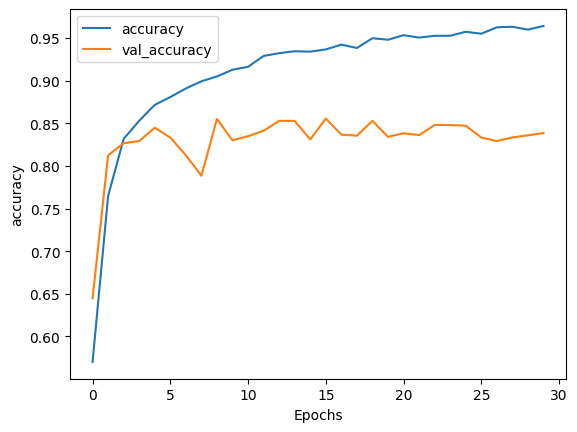

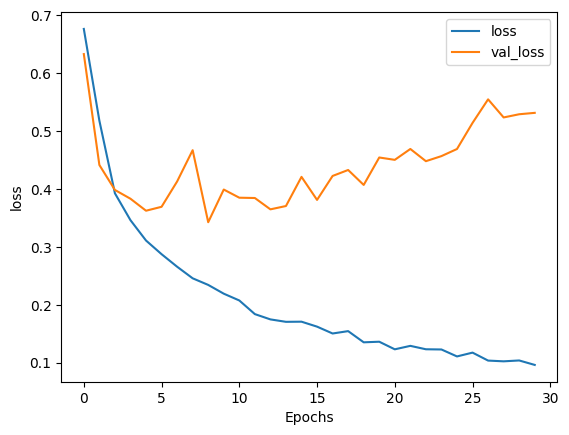

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Visualisation

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])    #converting numbers back into words

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])     #converting numbers back into words

print(decode_sentence(training_padded[0]))  # converts it back to words
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [13]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #vocab_size, embedding_dim

(10000, 16)


This code exports word embeddings into two files: vecs.tsv (for the embeddings) and meta.tsv (for the corresponding words). 

retrieves each word and its embedding-> write them into the respective files

In [14]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [15]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [16]:
sentence = ["Oh, how thrilling! Writing a bunch of numbers and words to files—truly the pinnacle of excitement in programming."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
[[0.06099903]]


In [17]:
sentence = ["granny starting to fear unicorns in the garden maybe real"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


if (model.predict(padded)) > 0.5:
     print("Predicted: Sarcastic with a score of",model.predict(padded))
else:
    print("Predicted: Not Sarcastic with a score of",model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted: Sarcastic with a score of [[0.95029175]]


In [18]:
df=pd.read_csv(r"C:\Nistha\Insta\Apify_776.csv",nrows=100)

In [19]:
df.head()

,commentText,commentatorProfilePicUrl,commentatorUserName,postInfo/alt,postInfo/caption,postInfo/coauthorProducers/0/id,postInfo/coauthorProducers/0/is_verified,postInfo/coauthorProducers/0/profile_pic_url,postInfo/coauthorProducers/0/username,postInfo/coauthorProducers/1/id,...,postInfo/taggedUsers/19/is_verified,postInfo/taggedUsers/19/profile_pic_url,postInfo/taggedUsers/19/username,postInfo/timestamp,postInfo/type,postInfo/url,postInfo/videoDuration,postInfo/videoPlayCount,postInfo/videoUrl,postInfo/videoViewCount
0,❤️❤️❤️❤️❤️👏👏,https://scontent-ber1-1.cdninstagram.com/v/t51...,davidabeck06,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0
1,This took decades,https://scontent-ber1-1.cdninstagram.com/v/t51...,shuana_abdul_wahip,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0
2,Love bonsai! It's fantastic 💚❤️❤️🔥🙌🙌🍃,https://scontent-ber1-1.cdninstagram.com/v/t51...,karladomli,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0
3,❤️❤️❤️,https://scontent-ber1-1.cdninstagram.com/v/t51...,ipekdalkirann,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0
4,👏👏👏❤️❤️❤️❤️🔥🔥🔥🔥,https://scontent-ber1-1.cdninstagram.com/v/t51...,farar_az_heyvanat,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0


In [20]:
for idx, i in enumerate(df['commentText']):
    if pd.isna(i):
        print('no_emoji')
        df.at[idx, 'sarcasmValue'] = None  # Set the sarcasm value as None if the comment is missing
    else:
        sequences = tokenizer.texts_to_sequences([i])  # Pass the comment as a list
        padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

        prediction = model.predict(padded)  # Get the prediction
        sarcasm_score = prediction[0][0]  # Extract the scalar value from the prediction array
        
        if sarcasm_score > 0.5:
            print("Predicted: Sarcastic with a score of", sarcasm_score)
            df.at[idx, 'sarcasmValue'] = sarcasm_score  # Update the sarcasm value for this row
        else:
            print("Predicted: Not Sarcastic with a score of", sarcasm_score)
            df.at[idx, 'sarcasmValue'] = sarcasm_score  # Update the sarcasm value for this row


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted: Not Sarcastic with a score of 0.37178382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted: Not Sarcastic with a score of 0.0065108077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: Not Sarcastic with a score of 0.018653726
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: Not Sarcastic with a score of 0.37178382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted: Not Sarcastic with a score of 0.37178382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: Not Sarcastic with a score of 0.37178382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: Not Sarcastic with a score of 0.097023174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted: Not Sarcastic with a score of 0.37178382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: Sarcastic with a score of 0.6561289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted: Sarcastic with a score of 0.8285333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted: Not Sarcastic with a score of 0.41077095
1/1 ━━━━━━━━━━━

In [21]:
df.head()

,commentText,commentatorProfilePicUrl,commentatorUserName,postInfo/alt,postInfo/caption,postInfo/coauthorProducers/0/id,postInfo/coauthorProducers/0/is_verified,postInfo/coauthorProducers/0/profile_pic_url,postInfo/coauthorProducers/0/username,postInfo/coauthorProducers/1/id,...,postInfo/taggedUsers/19/profile_pic_url,postInfo/taggedUsers/19/username,postInfo/timestamp,postInfo/type,postInfo/url,postInfo/videoDuration,postInfo/videoPlayCount,postInfo/videoUrl,postInfo/videoViewCount,sarcasmValue
0,❤️❤️❤️❤️❤️👏👏,https://scontent-ber1-1.cdninstagram.com/v/t51...,davidabeck06,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0,0.371784
1,This took decades,https://scontent-ber1-1.cdninstagram.com/v/t51...,shuana_abdul_wahip,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0,0.006511
2,Love bonsai! It's fantastic 💚❤️❤️🔥🙌🙌🍃,https://scontent-ber1-1.cdninstagram.com/v/t51...,karladomli,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0,0.018654
3,❤️❤️❤️,https://scontent-ber1-1.cdninstagram.com/v/t51...,ipekdalkirann,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0,0.371784
4,👏👏👏❤️❤️❤️❤️🔥🔥🔥🔥,https://scontent-ber1-1.cdninstagram.com/v/t51...,farar_az_heyvanat,NaN,Do you know the story behind one of North Amer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2025-01-19T14:08:44.000Z,Video,https://www.instagram.com/p/DFAov8-g1eU/,49.323,1096064.0,https://scontent-phx1-1.cdninstagram.com/o1/v/...,326361.0,0.371784


In [22]:
df['commentatorUserName'].value_counts()

commentatorUserName
karladomli             2
hipster                2
xo_xo_sweety_          2
liquidgoldhoneyy       2
davidabeck06           1
                      ..
dr.gunel_aliyeva22     1
butterfly_enchanted    1
niquelined             1
huseni._.chaki         1
jilly390               1
Name: count, Length: 96, dtype: int64

In [23]:
df=df[['commentText','sarcasmValue','commentatorUserName']]
df.to_csv(r'C:\Nistha\Insta\WORKING\final.csv')

In [24]:
for i in df.columns:
    print(i,":",df[i].value_counts().sum(),"\n---------------------------------------------------")

commentText : 100 
---------------------------------------------------
sarcasmValue : 100 
---------------------------------------------------
commentatorUserName : 100 
---------------------------------------------------
